In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from yellowbrick.cluster import SilhouetteVisualizer

# Background
The department of developmental biology is interested in exploring if expression data from a number of genes can be used to identify specific cell types. They used a publicly available dataset to run a pilot study and explore if there are specific patterns in the data supporting their hypothesis (to be used in question number 1). Assuming that their hypothesis would be supported by their analysis, they also initiated a parallel study sequencing their own data, for which the information about each cell type was available (to be used in question 2).

# Goals
To evaluate the performance of different clustering techniques identifying cell types based on gene expression (use only the pilot dataset).
* Compare quantitatively the performance of K-means, DBSCAN and OPTICS identifying clusters of gene expression that may be associated with cell types. Justify parameter selection independently for each algorithm. How similar are the results obtained from the three algorithms?
* What is the most likely number of cell types based on previous results? Justify the answer using only the pilot dataset.

To evaluate the performance of clustering techniques on a separate dataset (use the test dataset).
* Evaluate quantitatively the performance of the previous methods in the new dataset for which the cell types are known.
* Compare the performance of previous clustering techniques with linear discriminant analysis. Justify any difference in the obtained results.


In [2]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
pilotDataDF = pd.read_excel(f'{WORK_DIR}/Pilot_GeneExpressionData.xlsx')
pilotDataDF.columns = pilotDataDF.columns.str.lower().str.replace('expression - ', '').str.replace(' ', '_')
print(pilotDataDF.shape)
pilotDataDF.head(5)

(4894, 100)


,gene_000,gene_001,gene_002,gene_003,gene_004,gene_005,gene_006,gene_007,gene_008,gene_009,...,gene_090,gene_091,gene_092,gene_093,gene_094,gene_095,gene_096,gene_097,gene_098,gene_099
0,-1.237358,38.642584,10.884096,-3.339147,-1.555339,14.407978,55.770644,13.109897,11.652522,365.928797,...,68.662581,1.343553,20.079415,48.342081,5.199666,8.582158,325.058081,413.412361,655.467974,224.045697
1,-2.093798,39.399697,5.863917,-2.270315,-0.486506,9.469040,60.626785,9.492048,17.507333,365.129055,...,79.764261,12.445233,11.953880,52.238938,-0.116666,4.537059,321.012982,413.379518,655.339022,224.529880
2,14.470170,36.381095,-9.510318,15.156488,16.940296,-7.909798,74.697892,-4.465825,12.619979,335.499965,...,73.074749,5.755721,16.613457,55.059154,4.151859,5.631896,322.107819,411.768780,655.437052,224.088647
3,-3.074387,39.030519,9.228330,-3.344361,-1.560553,12.287957,58.692670,11.807070,15.281483,366.153522,...,68.135925,0.816897,22.837977,49.460210,7.882375,8.555372,325.031295,411.803469,655.470397,223.914104
4,-0.898006,39.088386,4.945750,-1.124616,0.659192,8.204751,61.690854,8.721729,16.890130,362.689877,...,77.619769,10.300741,14.478982,50.745263,1.451071,5.621678,322.097601,413.323667,655.363004,224.430544


# Pilot Data
## EDA & Data Pre-Processing
### Visualize Gene Expression Data

In [3]:
def gene_expression_displot(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of gene expression data
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('default')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.distplot(df[feature], hist=True, kde=False, bins=bins, ax=plots[i])
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        if i % n_col == 0:
            plots[i].set_ylabel('Count')
        else:
            plots[i].set_ylabel('')
        
    plt.show()
    


Gene Expression Distributions:



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


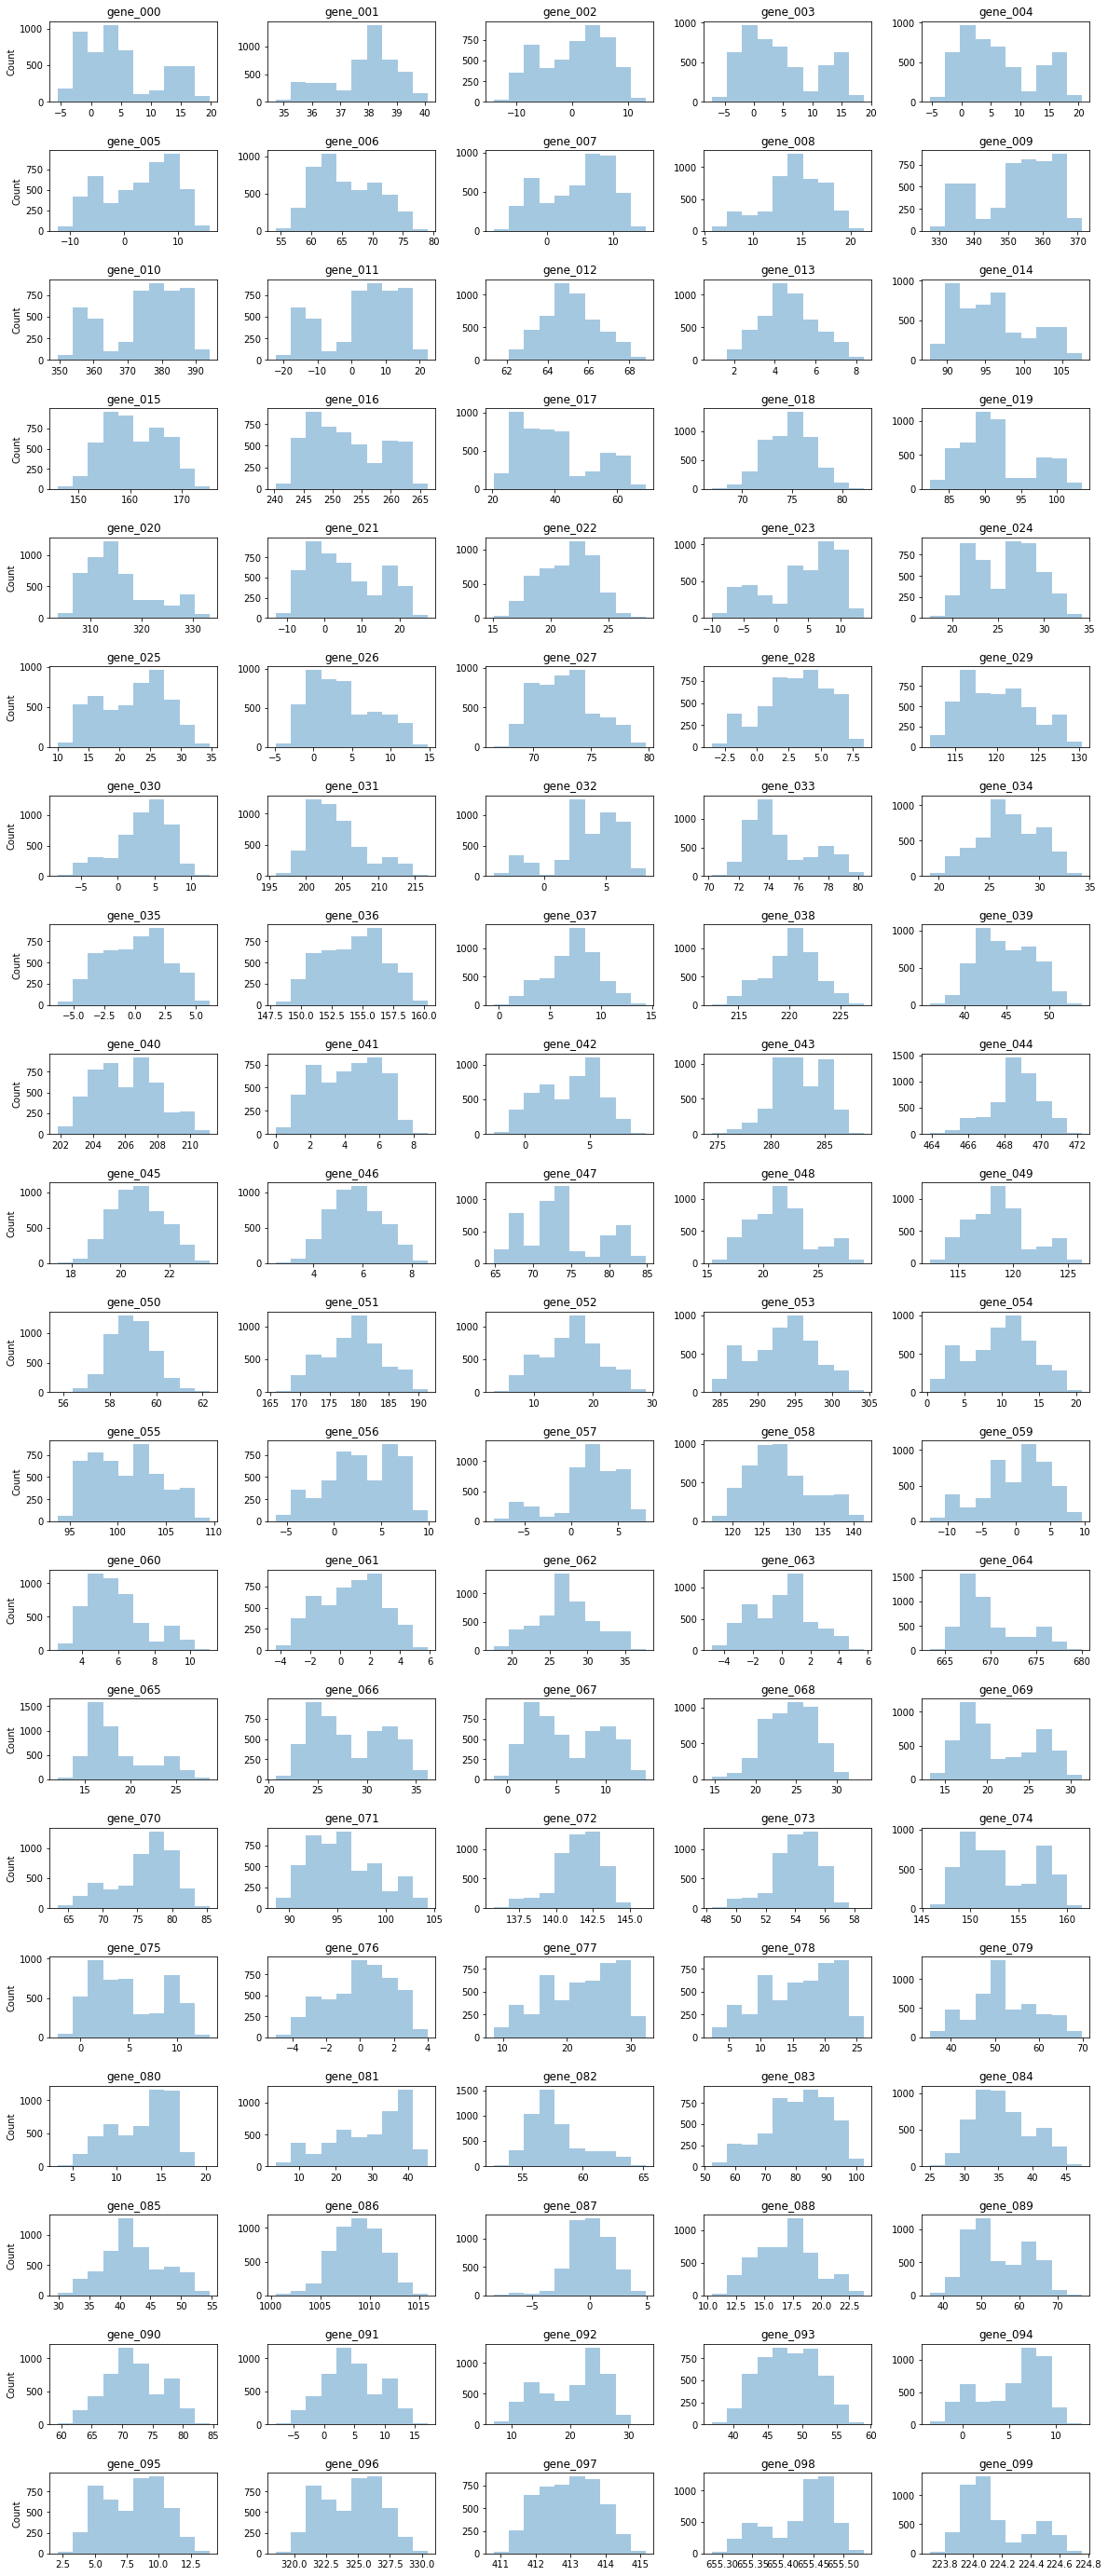

In [4]:
# Gene expression distributions
print('\nGene Expression Distributions:\n')
gene_expression_displot(df=pilotDataDF, n_col=5, bins=10, fig_width=20, fig_height=50, hspace=0.6, wspace=0.3)

### Checking for Missing Data

In [5]:
print(f'{sum(pilotDataDF.isnull().sum())} missing entries')

0 missing entries


### Standardize Data

In [6]:
scaler = StandardScaler()                    # Initialize scaler
X_scaled = scaler.fit_transform(pilotDataDF) # Train scaler and scale data

## Dimensionality Reduction with PCA
Many clustering algorithms (e.g. K-means) work poorly (or don't work at all) with high-dimensional data. Given that this data set contains 100 features, we will implement a dimensionality reduction step with PCA. Rather than aribtrarily selecting a number of dimensions to reduce down to we will keep the top dimensions (in terms of explained variance) that collectively explain 95% of the variance in the data set.

In [7]:
# Perform PCA preserving 95% explained variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
X_reducedDF = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(len(X_reduced[0]))])
print(f'Dimensions remaining after dimensionality reduction: {len(X_reduced[0])}')

Dimensions remaining after dimensionality reduction: 6


## K-means
### Choosing Optimal Number of Clusters

Based on the plots below, the *optimal* number of clusters for K-means is somewhere between 8-10. In the silhouette score method, this is the point where silhouette score is maximized (looks to be at *k=9* or *k=10*). In the elbow method, this is the point where there are diminishing returns in limiting the sum of squared distances (inertia) by increasing *k* (looks to be at *k=8* or *k=9*). The optimal value of *k* is not obvious here, which is one of the limitations of K-means. In the next cell I look at silhouette visualizations to make a final decision on *k*.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

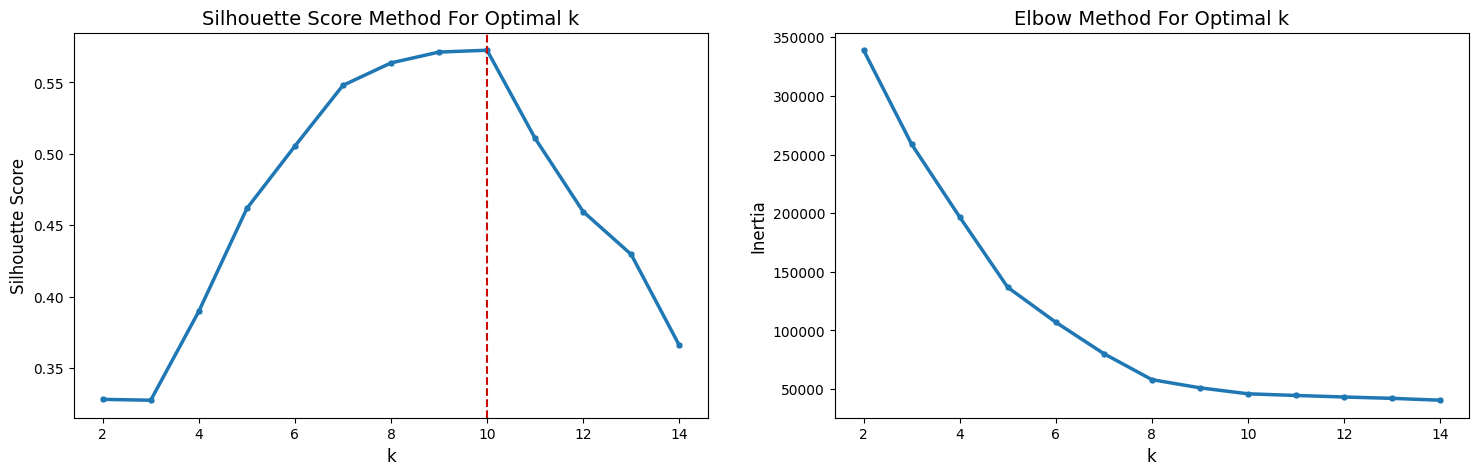

In [8]:
# Run k-means for n_cluster 2 to 15 and store corresponding silhouette/inertia scores
silhouetteList = []
inertiaList = []
for k in range(2, 15):
    kmeans_clusterer = KMeans(n_clusters=k, random_state=1)
    kmeans = kmeans_clusterer.fit(X_reduced)
    silhouetteList.append(silhouette_score(X_reduced, kmeans.labels_, metric='euclidean'))
    inertiaList.append(kmeans.inertia_)

# Set figure space
plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Silhouette method
sns.lineplot(x=range(2, 15), y=silhouetteList, linewidth=2.5, ax=ax[0])
sns.scatterplot(x=range(2, 15), y=silhouetteList, s=25, ax=ax[0])
ax[0].axvline(x=10, c='r', linestyle='--')
ax[0].set_xlabel('k', size=12)
ax[0].set_ylabel('Silhouette Score', size=12)
ax[0].set_title('Silhouette Score Method For Optimal k', size=14)

# Elbow method
sns.lineplot(x=range(2, 15), y=inertiaList, linewidth=2.5, ax=ax[1])
sns.scatterplot(x=range(2, 15), y=inertiaList, s=25, ax=ax[1])
ax[1].set_xlabel('k', size=12)
ax[1].set_ylabel('Inertia', size=12)
ax[1].set_title('Elbow Method For Optimal k', size=14)

In general, I tend to prefer the silhoutte score method since it measures both within-cluster cohesion and between-cluster separation. In the silhouette plots below we can judge the optimal number of clusters based on two criteria: (1) we do not want the score of any cluster to fall below the average score (red line)? and (2) we want there to be minimal fluctuation between scores.

Based on the criteria laid out, *k=8* is clearly sub-optimal, and it is still a real toss up between *k=9* and *k=10*. I'm going to proceed with using *k=10* since the average silhoutte score is the greatest (*only slightly*).

**Final Decision: *k=10***

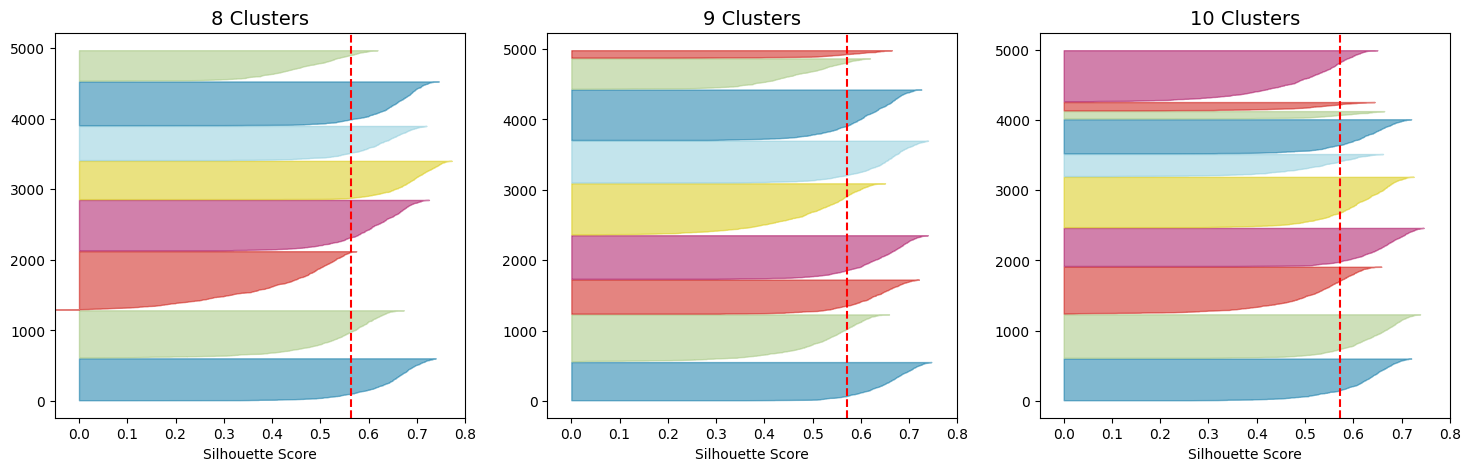

In [9]:
# Checking silhouette score plots for k=8, 9, 10
plt.style.use('default')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, k in enumerate([8, 9, 10]):
    
    # Fit k-means
    kmeans_clusterer = KMeans(n_clusters=k, random_state=1)
    kmeans = kmeans_clusterer.fit(X_reduced)
    
    # Visualize
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[i])
    visualizer.fit(X_reduced)
    ax[i].set_xlim(-0.05, 0.8)
    ax[i].set_title(f'{k} Clusters', size=14)
    ax[i].set_xlabel(f'Silhouette Score')

### K-means Final Model

In [10]:
# Fit model
kmeans_clusterer = KMeans(n_clusters=10, random_state=1)
kmeans = kmeans_clusterer.fit(X_reduced)

# Add cluster assignments to reduced DF
X_reducedDF['kmeans_cluster'] = kmeans.labels_

### K-means Cluster Visualization
Below we use a PCA biplot to visualize cluster assignments based on principal components 1 & 2. It seems like reasonable assignments have been made, although there is clear overlap in the clusters in 2D-space. Below we view cluster assignments in 3D-space to see if seemingly overlapping clusters are separated on principal component 3.

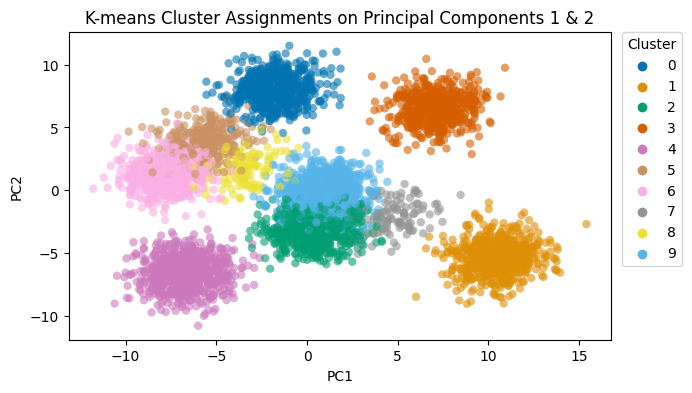

In [11]:
# Plot PCA with K-Means cluster assignments
plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', data=X_reducedDF, palette='colorblind', linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 10})
plt.title('K-means Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Cluster', borderaxespad=0)

As expected, the clusters are better separated on PC3.

<IPython.core.display.Javascript object>


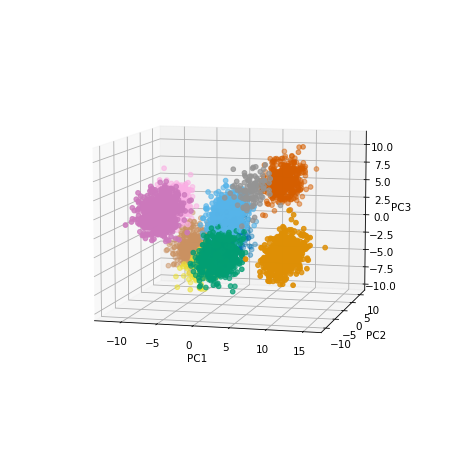

Text(0.5, 0, 'PC3')

In [12]:
#  Plot 3D PCA with K-Means cluster assignments
# Sources: 
# - https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot-in-matplotlib
# - https://stackoverflow.com/questions/38364435/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook

# This line of code is used to be able to rotate the 3D plot
%matplotlib notebook

# Create the figure space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

# Plot the values
palette = ListedColormap(sns.color_palette('colorblind', len(set(kmeans.labels_))).as_hex())
ax.scatter(X_reducedDF['PC1'], X_reducedDF['PC2'], X_reducedDF['PC3'], c=X_reducedDF['kmeans_cluster'].map(palette))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [13]:
# Set back to inline for remaining analysis
%matplotlib inline

## DBSCAN Clustering

### DBSCAN $\epsilon$ Selection
We will use the k-distance method to select an approximate 'optimal' value for $\epsilon$. For k (or the min_samples parameter in DBSCAN) we will use the heuristic of min_samples = 2*n_dimension, which is 12 in this case (this heuristic was loosely suggested by the authors of DBSCAN). In the k-distance plot below, we observe a knee at roughly distance = 2. We'll go ahead and use $\epsilon = 2$.

Text(0, 0.5, '12-N Distance')

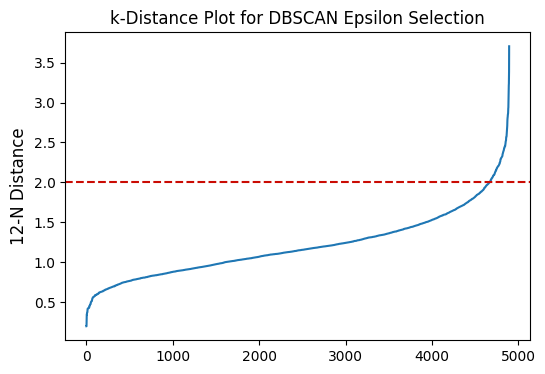

In [14]:
# Fit k-nn and extract distances
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)

# Sort k-nn distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Plot to find elbow
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=range(1, len(distances) + 1), y=distances)
plt.axhline(y=2, c='r', linestyle='--')
plt.title('k-Distance Plot for DBSCAN Epsilon Selection', size=12)
plt.ylabel('12-N Distance', size=12)

### DBSCAN Final Model
The DBSCAN algorithm denotes noise (i.e., outliers) with the -1 label. Roughly 10% of observations were labeled as noise here.

In [15]:
# Fit model
dbscan = DBSCAN(eps=2, min_samples=12)
dbscan.fit(X_reduced)

# Add cluster assignments to reduced DF
X_reducedDF['dbscan_cluster'] = dbscan.labels_
print(f"Number of outliers: {list(dbscan.labels_).count(-1)}")

Number of outliers: 568


### DBSCAN Cluster Visualization

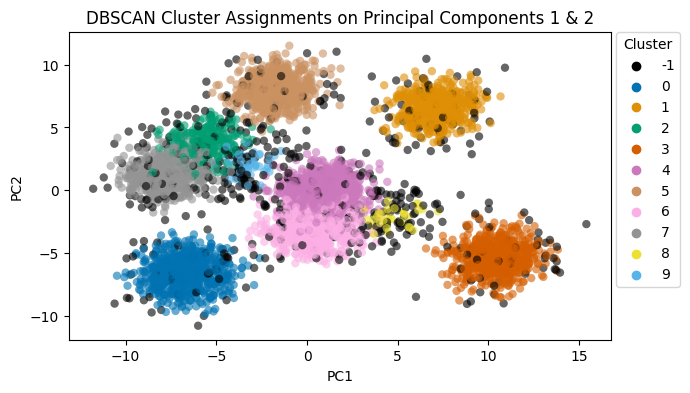

In [16]:
# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', len(set(X_reducedDF.dbscan_cluster))-1).as_hex()):
    palette.append(hex_code)

# Plot PCA with DBSCAN cluster assignments
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_cluster', data=X_reducedDF, 
                palette=sns.color_palette(palette), linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 10})
plt.title('DBSCAN Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Cluster', borderaxespad=0)

## OPTICS
Here I'm going to opt for the non-auto method and use similar parameters as for DBSCAN.

In [17]:
# Fit model
optics = OPTICS(cluster_method="dbscan", eps=2, min_samples=12)
#optics = OPTICS(cluster_method='xi', eps=None)
optics.fit(X_reduced)

# Add cluster assignments to reduced DF
X_reducedDF['optics_cluster'] = optics.labels_
print(f"Number of outliers: {list(optics.labels_).count(-1)}")

Number of outliers: 577


### OPTICS Reachability Plot

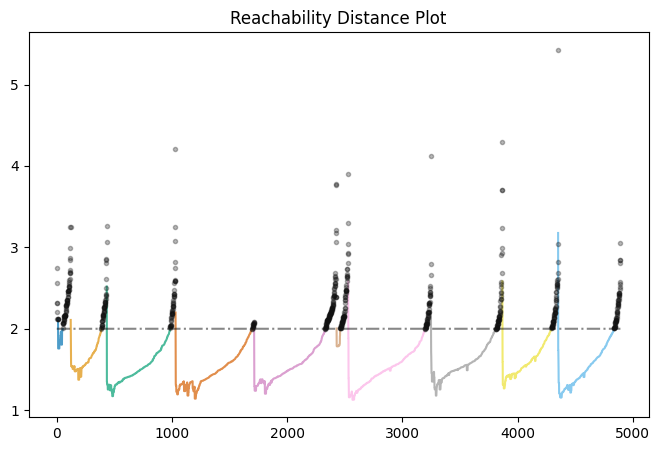

In [18]:
# Reachability plot 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# Get reachability information from clusterer
space = np.arange(len(X_reduced))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

# Set figure space
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Reachability Distance Plot")

# Set palette
palette = list(sns.color_palette('colorblind', 10).as_hex())

# Plot clusters
for cluster, color in zip(range(0, 10), palette):
    Xk = space[labels == cluster]
    Rk = reachability[labels == cluster]
    ax.plot(Xk, Rk, color, alpha=0.7)
    
# Plot noise
ax.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax.plot(space, np.full_like(space, 2.0, dtype=float), "k-.", alpha=0.5)

### OPTICS Cluster Visualization

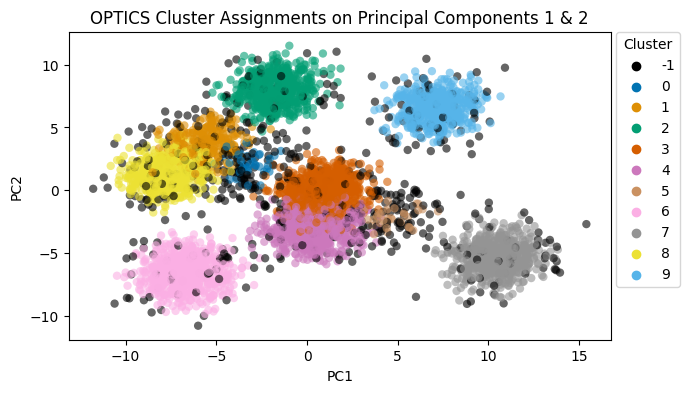

In [19]:
# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', len(set(X_reducedDF.optics_cluster))-1).as_hex()):
    palette.append(hex_code)

# Plot PCA with DBSCAN cluster assignments
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x='PC1', y='PC2', hue='optics_cluster', data=X_reducedDF, 
                palette=sns.color_palette(palette), linewidth=0, alpha=.6)
plt.rcParams.update({'font.size': 10})
plt.title('OPTICS Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Cluster', borderaxespad=0)

## Pilot Set Clustering Discussion
### Quantitative Comparison

To compare methods quantitatively we can use the silhoutte score metric. Silhouette scores measure how well-defined the formed clusters are by measuring both within-cluster cohesion and between-cluster separation. I am a little skeptical here, however, using this metric to compare K-means results to the density-based clustering results. I'll describe my skepticism below.

I had suspicion that noise samples in both DBSCAN and OPTICS (labeled as -1) would negatively impact silhouette score. My thought was that sklearn would treat samples labeled with -1 as samples belonging to a similar cluster rather than treat them as outliers. I checked for this below.

In [20]:
# Silhouette score comparison

# No outlier removal scores
silScores_rawLabels = [
    round(silhouette_score(X_reduced, kmeans.labels_, metric='euclidean'), 3),
    round(silhouette_score(X_reduced, dbscan.labels_, metric='euclidean'), 3),
    round(silhouette_score(X_reduced, optics.labels_, metric='euclidean'), 3)
]

# Outlier removal for density-based methods
# DBSCAN remove outliers
X_nonNoiseDBSCAN = X_reducedDF[X_reducedDF['dbscan_cluster'] != -1]

# OPTICS remove outliers
X_nonNoiseOPTICS = X_reducedDF[X_reducedDF['optics_cluster'] != -1]

# Outlier removal scores
silScores_noNoise = [
    round(silhouette_score(X_reduced, kmeans.labels_, metric='euclidean'), 3),
    round(silhouette_score(X_nonNoiseDBSCAN.to_numpy(), X_nonNoiseDBSCAN.dbscan_cluster, metric='euclidean'), 3),
    round(silhouette_score(X_nonNoiseOPTICS.to_numpy(), X_nonNoiseOPTICS.optics_cluster, metric='euclidean'), 3)
]

# Display results as a table
print('Silhouette Scores:')
pd.DataFrame({
    'Clustering Method': ['K-means', 'DBSCAN', 'OPTICS'],
    'No Outlier Removal': silScores_rawLabels,
    'Outlier Removal': silScores_noNoise
})


Silhouette Scores:


,Clustering Method,No Outlier Removal,Outlier Removal
0,K-means,0.573,0.573
1,DBSCAN,0.451,0.674
2,OPTICS,0.449,0.675


Clearly sklearn is treating the -1 label as a unique cluster rather than noise. So once outliers are removed, the density-based methods have 'better' (higher) silhouette scores than K-means. But I am still skeptical of the results here. Of course silhouette score will go up as we remove outliers; by removing outliers, we are artificially making clusters more cohesive and better-separated since all of the questionable noise points that are on the edges of the clusters are being removed. So it seems impossible to give a definitive answer of which clustering method works the best here. It is completely context-dependent (e.g., is it important to remove outliers in this context or is it important to force everything into a cluster?)

### Method Similarity
For similarity measurements we can use the adjusted rand-index score metric, where a score of 1 indicates perfect pairwise agreement. This metric is symmetric, meaning that it does not matter which labels we use as the 'truth'; results will be the same.

In [21]:
ari_scores = [
    round(adjusted_rand_score(kmeans.labels_, dbscan.labels_), 3),
    round(adjusted_rand_score(kmeans.labels_, optics.labels_), 3),
    round(adjusted_rand_score(dbscan.labels_, optics.labels_), 3)
]

ri_scores = [
    round(rand_score(kmeans.labels_, dbscan.labels_), 3),
    round(rand_score(kmeans.labels_, optics.labels_), 3),
    round(rand_score(dbscan.labels_, optics.labels_), 3)
]

# Display results as a table
print('Clustering Similarity (w/ ARI):')
pd.DataFrame({
    'Method Comparison': ['K-means vs DBSCAN', 'K-means vs OPTICS', 'DBSCAN vs OPTICS'],
    'Adjusted Rand-Index': ari_scores,
    'Rand-Index (Unadjusted)': ri_scores
})

Clustering Similarity (w/ ARI):


,Method Comparison,Adjusted Rand-Index,Rand-Index (Unadjusted)
0,K-means vs DBSCAN,0.846,0.968
1,K-means vs OPTICS,0.844,0.968
2,DBSCAN vs OPTICS,0.996,0.999


As expected, there is *very* strong agreement between the density-based methods. There is also good agreement between K-means and the two density-based methods; outlier labels likely drive some of the disagreement. Unadjusted rand-index scores are quite high between K-means and DBSCAN/OPTICS.

### Conclusion
Based on our results here, there are likely **10 distinct cell types** in the dataset. All methods found 10 clusters.

# Test Data
Now we will evaluate the performance of the clustering techniques on a separate test dataset. First, we will evaluate quantitatively the performance of the previous methods in the new dataset for which the cell types are known. Second, we will compare the performance of previous clustering techniques with linear discriminant analysis (LDA). Justify any difference in the obtained results.

## Data Pre-Processing
### Import Data

In [22]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
testDataDF = pd.read_excel(f'{WORK_DIR}/Test_GeneExpressionData.xlsx')
testDataDF.columns = testDataDF.columns.str.lower().str.replace('expression - ', '').str.replace(' ', '_')
print(testDataDF.shape)
testDataDF.head(5)

(100, 101)


,gene_000,gene_001,gene_002,gene_003,gene_004,gene_005,gene_006,gene_007,gene_008,gene_009,...,gene_091,gene_092,gene_093,gene_094,gene_095,gene_096,gene_097,gene_098,gene_099,coded_cell_type
0,8.984394,37.741801,-9.092783,10.231043,12.014851,-6.138217,74.972049,-2.889118,18.956564,344.611960,...,6.079468,15.182211,49.780208,1.759574,6.641485,323.117408,413.801148,655.389300,224.346571,9
1,0.746108,38.347763,7.960910,-0.795883,0.987925,11.312757,58.574879,10.647093,12.251776,361.925449,...,2.853169,17.912978,50.614694,4.135610,7.405521,323.881444,413.071821,655.447507,224.103939,8
2,-2.021968,38.800012,8.460022,-2.092349,-0.308541,10.885142,59.819295,10.933739,14.755650,363.831839,...,2.271848,21.206950,51.405758,6.954013,7.645596,324.121519,411.622131,655.463936,223.942369,10
3,15.914165,35.761129,-7.786719,14.379773,16.163581,-6.444391,71.530994,-2.355882,9.484284,335.040283,...,7.499159,19.202052,48.298486,4.550249,7.148056,323.623979,412.923455,655.401787,224.259826,1
4,15.247312,36.093027,-8.066194,13.775188,15.558996,-6.385851,71.746761,-2.425104,10.357679,336.040483,...,5.167867,22.214426,45.996865,6.387098,8.512514,324.988437,412.929413,655.416881,224.179769,1


### Check for Missing Data

In [23]:
# Check for missing data
print(f'{sum(testDataDF.isnull().sum())} missing entries')

0 missing entries


### Standardize Data

In [24]:
def X_y_split(df, target: str, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y


X_test, y_cellTypes = X_y_split(testDataDF, 'coded_cell_type', to_numpy=True) # Split data into X and y
scaler = StandardScaler()                                                     # Initialize scaler
X_testScaled = scaler.fit_transform(testDataDF)                               # Train scaler and scale data

## Dimensionality Reduction with PCA
Similar to the pilot dataset, 95% of the variance in the gene expression data can be explained by 6 principal components.

In [25]:
# Perform PCA preserving 95% explained variance
pca = PCA(n_components=0.95)
X_testRed = pca.fit_transform(X_testScaled)
X_testRedDF = pd.DataFrame(X_testRed, columns=[f'PC{i+1}' for i in range(len(X_testRed[0]))])
X_testRedDF['cell_type'] = y_cellTypes

print(f'Dimensions remaining after dimensionality reduction: {len(X_testRed[0])}')

Dimensions remaining after dimensionality reduction: 6


## Clustering
Below we will use a similar clustering process on our test set. This set contains "ground truth" cell types that we can compare our clustering results to. I'm going to re-tune hyperparameters again here since we only have 100 observations and the DBSCAN/OPTICS min_samples=12 parameter would likely prevent cluster formation. In my opinion, it'll also be more interesting to see if these clustering methods can pick out the correct number of cell types with a more limited number of samples.

## K-means
### Choosing Optimal Number of Clusters
Again there is no clear answer to the optimal number of clusters in k-means. It's becoming apparent why this method is often limited in practice, especially when domain knowledge is limited.

The two *k*'s with the greatest silhouette scores are *k=8* and *k=10*. Two clusters do not exceed the average silhouette score in the *k=8* silhouette plot, which makes it difficult to rationalize choosing *k=8*. I'm once again going to proceed with *k=10* since only one cluster does not exceed the average silhouette score and since this value of *k* is consistent with what we saw in the pilot dataset.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

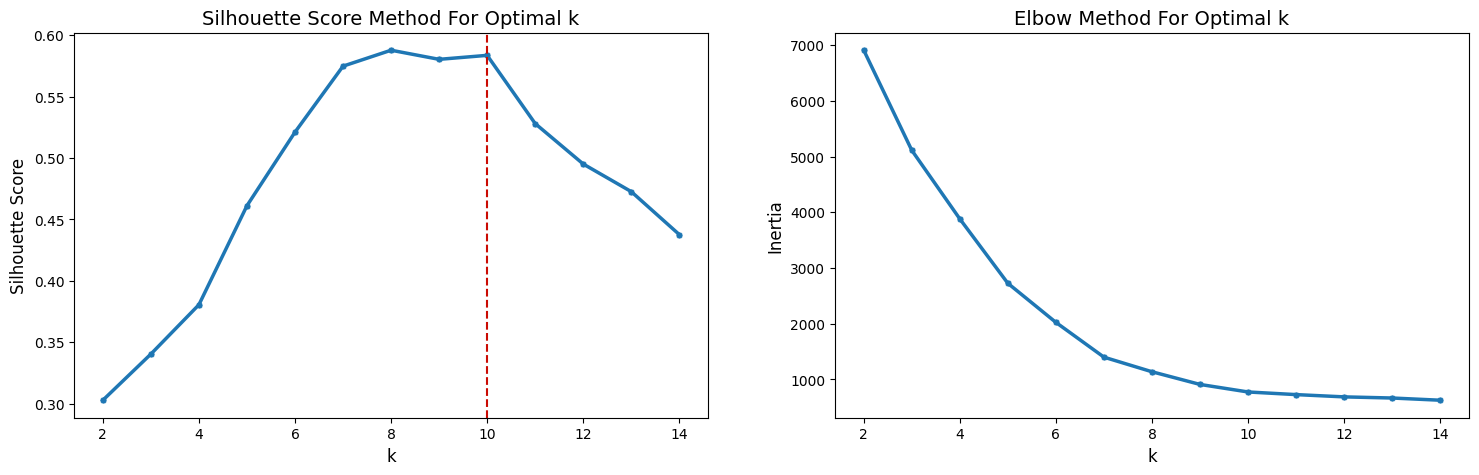

In [26]:
# Run k-means for n_cluster 2 to 15 and store corresponding silhouette/inertia scores
silhouetteList = []
inertiaList = []
for k in range(2, 15):
    kmeans_clusterer = KMeans(n_clusters=k, random_state=1)
    kmeans = kmeans_clusterer.fit(X_testRed)
    silhouetteList.append(silhouette_score(X_testRed, kmeans.labels_, metric='euclidean'))
    inertiaList.append(kmeans.inertia_)

# Set figure space
plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Silhouette method
sns.lineplot(x=range(2, 15), y=silhouetteList, linewidth=2.5, ax=ax[0])
sns.scatterplot(x=range(2, 15), y=silhouetteList, s=25, ax=ax[0])
ax[0].axvline(x=10, c='r', linestyle='--')
ax[0].set_xlabel('k', size=12)
ax[0].set_ylabel('Silhouette Score', size=12)
ax[0].set_title('Silhouette Score Method For Optimal k', size=14)

# Elbow method
sns.lineplot(x=range(2, 15), y=inertiaList, linewidth=2.5, ax=ax[1])
sns.scatterplot(x=range(2, 15), y=inertiaList, s=25, ax=ax[1])
ax[1].set_xlabel('k', size=12)
ax[1].set_ylabel('Inertia', size=12)
ax[1].set_title('Elbow Method For Optimal k', size=14)

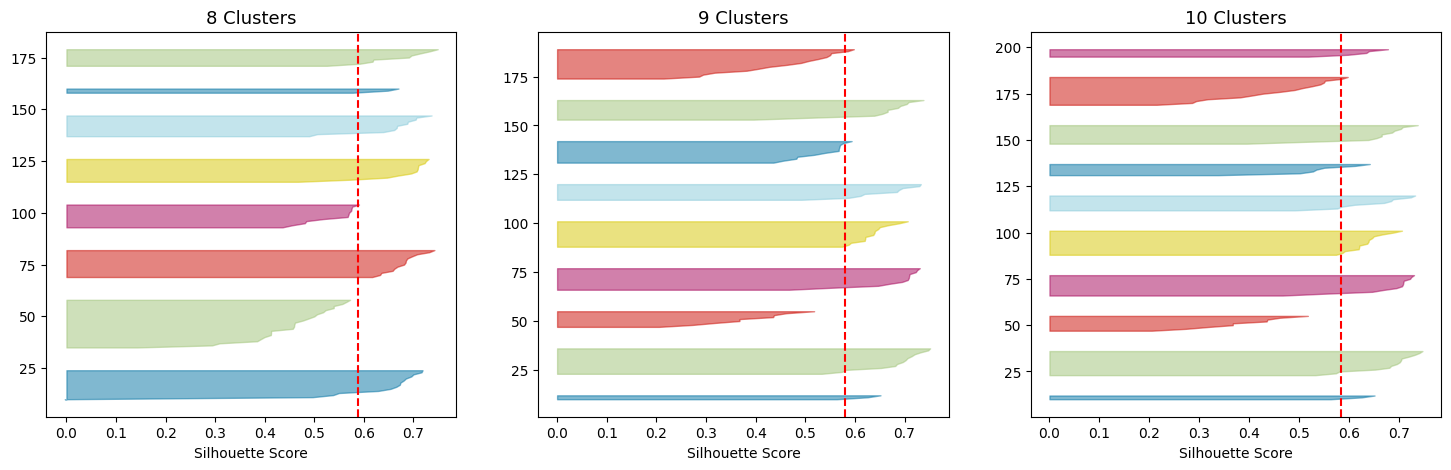

In [27]:
# Checking silhouette score plots for k=8, 9, 10
plt.style.use('default')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, k in enumerate([8, 9, 10]):
    
    # Fit k-means
    kmeans_clusterer = KMeans(n_clusters=k, random_state=1)
    kmeans = kmeans_clusterer.fit(X_testRed)
    
    # Visualize
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[i])
    visualizer.fit(X_testRed)
    ax[i].set_title(f'{k} Clusters', size=13)
    ax[i].set_xlabel(f'Silhouette Score')

### K-means Fitting & Cluster-Assignment Visualization

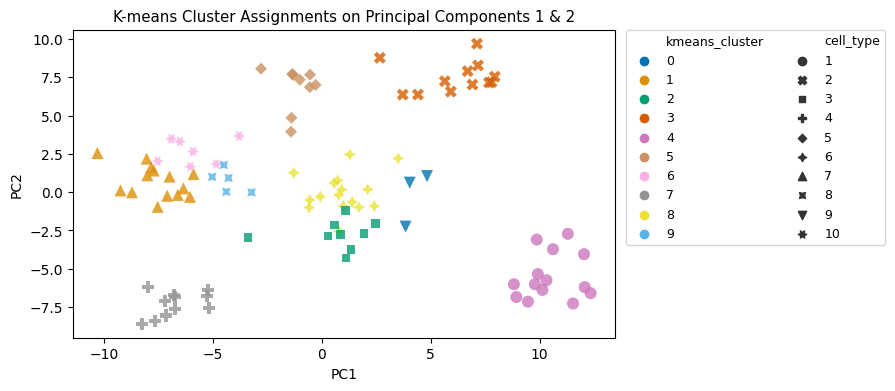

In [28]:
# Fit model
kmeans_clusterer = KMeans(n_clusters=10, random_state=1)
kmeans = kmeans_clusterer.fit(X_testRed)

# Add cluster assignments to reduced DF
X_testRedDF['kmeans_cluster'] = kmeans.labels_

# Set figure space
fig, ax = plt.subplots(figsize=(7, 4))
plt.rcParams.update({'font.size': 9})

# Plot PCA with K-Means cluster assignments
sns.scatterplot(x='PC1', y='PC2', hue='kmeans_cluster', style='cell_type', data=X_testRedDF,
                palette='colorblind', linewidth=0, alpha=.8, s=75)
plt.title('K-means Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=2)

### K-means Performance Evaluation
For performance evaluations we will use adjusted rand-index (ARI) scores. Below we see an ARI score of 1, which indicates perfect agreement between k-means cluster-assignments and actual cell types. This good of a result is unexpected, but confirmed when looking at color/shape agreement in the PCA plot above. Wow! I wouldn't expect K-means to perform this well.

In [29]:
print(f'ARI: {round(adjusted_rand_score(labels_true=X_testRedDF.cell_type, labels_pred=X_testRedDF.kmeans_cluster), 3)}')

ARI: 1.0


## DBSCAN
### DBSCAN $\epsilon$ Selection
Again, we will use the k-distance method to select an approximate 'optimal' value for $\epsilon$. The heuristic of using min_samples = 2*n_dimension won't be applied here since the number observations is relatively small. As such, we'll use min_samples = 3. In the k-distance plot below, we observe a knee at roughly 3-NN distance = 3.3-3.4. We'll go ahead and use $\epsilon = 3.4$; using a larger value for $\epsilon$ should limit the number of "noise" points.

Text(0, 0.5, '3-NN Distance')

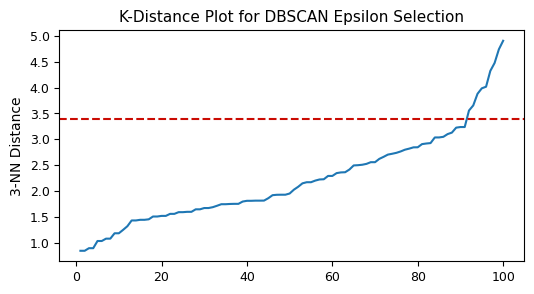

In [30]:
# Fit k-nn and extract distances
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_testRed)
distances, indices = neighbors_fit.kneighbors(X_testRed)

# Sort k-nn distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Plot to find elbow
fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(x=range(1, len(distances) + 1), y=distances)
plt.axhline(y=3.4, c='r', linestyle='--')
plt.title('K-Distance Plot for DBSCAN Epsilon Selection', size=11)
plt.ylabel('3-NN Distance', size=10)

### DBSCAN Fitting & Cluster-Assignment Visualization

Number of outliers: 15


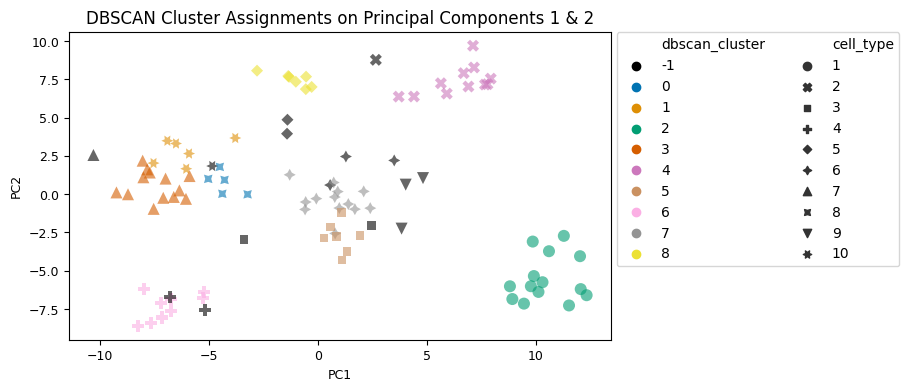

In [31]:
# Fit model
dbscan = DBSCAN(eps=3.4, min_samples=3).fit(X_testRed)

# Add cluster assignments to reduced DF
X_testRedDF['dbscan_cluster'] = dbscan.labels_
print(f"Number of outliers: {list(dbscan.labels_).count(-1)}")

# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', len(set(X_testRedDF.dbscan_cluster))-1).as_hex()):
    palette.append(hex_code)

# Set figure space
fig, ax = plt.subplots(figsize=(7, 4))
plt.rcParams.update({'font.size': 10})

# Plot PCA with DBSCAN cluster assignments
sns.scatterplot(
    x='PC1', y='PC2', hue='dbscan_cluster', data=X_testRedDF, style='cell_type',
                palette=sns.color_palette(palette), linewidth=0, alpha=.6, s=75)
plt.rcParams.update({'font.size': 10})
plt.title('DBSCAN Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, ncol=2)

### DBSCAN Performance Evaluation
An ARI score of 0.733 suggests reasonable agreement between the DBSCAN cluster assignments and cell types. One characteristic of DBSCAN and OPTICS, which is usually seen as a benefit, is that outliers (noise) aren't coerced into clusters. This algorithmic feature isn't working in favor of maximizing ARI score in this use-case, however, since all observations belong to a cell type. All data points marked as outliers by each algorithm will negatively impact ARI. We can see how noise-calling methods of clustering could be problematic in biomedicine.

In [32]:
print(f'ARI: {round(adjusted_rand_score(labels_true=X_testRedDF.cell_type, labels_pred=X_testRedDF.dbscan_cluster), 3)}')

ARI: 0.773


### OPTICS
Here I wanted to play around with the 'auto'/'xi' OPTICS cluster method. Admittedly I searched around and couldn't find reliable resources on hyperparameter tuning of xi, so I adjusted the parameter until I saw reasonable cluster formation on the principal components (without looking at the true cell type). I could have tuned this parameter to maximize ARI with respect to true cell type, but that would be cheating.

Number of outliers: 4


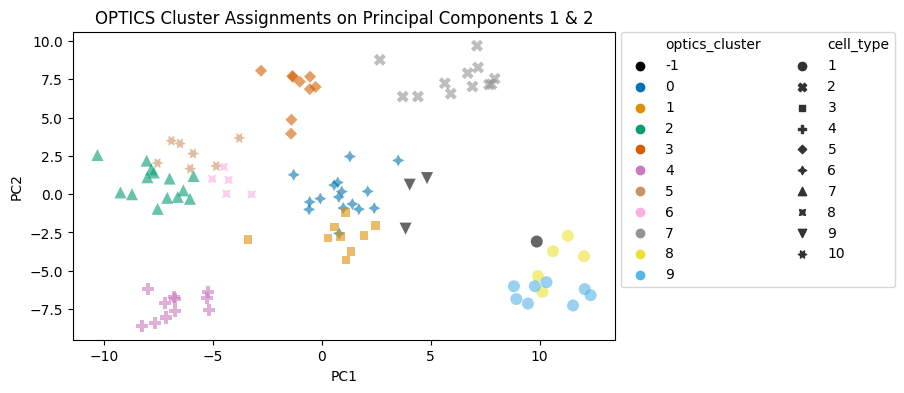

In [33]:
# Fit model
#optics = OPTICS(cluster_method="dbscan", eps=3.4, min_samples=3)
optics = OPTICS(cluster_method="xi", xi=0.01)
optics.fit(X_testRed)

# Add cluster assignments to reduced DF
X_testRedDF['optics_cluster'] = optics.labels_
print(f"Number of outliers: {list(optics.labels_).count(-1)}")

# Set palette with outlier set to black
palette = ['black']
for hex_code in list(sns.color_palette('colorblind', len(set(X_testRedDF.optics_cluster))-1).as_hex()):
    palette.append(hex_code)

# Set figure space
fig, ax = plt.subplots(figsize=(7, 4))
plt.rcParams.update({'font.size': 10})

# Plot PCA with DBSCAN cluster assignments
sns.scatterplot(x='PC1', y='PC2', hue='optics_cluster', data=X_testRedDF, style='cell_type',
                palette=sns.color_palette(palette), linewidth=0, alpha=.6, s=75)
plt.rcParams.update({'font.size': 10})
plt.title('OPTICS Cluster Assignments on Principal Components 1 & 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, ncol=2)

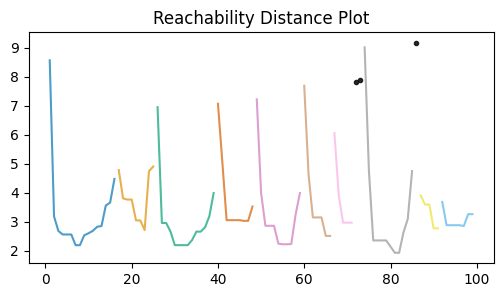

In [34]:
# Reachability plot 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
# Get reachability information from clusterer
space = np.arange(len(X_testRed))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

# Set figure space
fig, ax = plt.subplots(figsize=(6, 3))
plt.title("Reachability Distance Plot")

# Set palette
palette = list(sns.color_palette('colorblind', 10).as_hex())

# Plot clusters
for cluster, color in zip(range(0, 10), palette):
    Xk = space[labels == cluster]
    Rk = reachability[labels == cluster]
    ax.plot(Xk, Rk, color, alpha=0.7)
    
# Plot noise
ax.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.9)

### OPTICS Performance Evaluation
An ARI score of 0.938 suggests strong agreement between the OPTICS cluster assignments and cell types. As mentioned for DBSCAN, the outlier-labeling feature of OPTICS makes a perfect ARI score difficult to achieve since any called outlier will negatively impact ARI. 

On a separate note, it appears that cell type 9 was completely undetectable (all points labeled as noise) by both the DBSCAN and OPTICS methods; perhaps further hyperparameter tuning would fix this, but this is a clear limitation of these clustering methods for this application.

In [35]:
print(f'ARI: {round(adjusted_rand_score(labels_true=X_testRedDF.cell_type, labels_pred=X_testRedDF.optics_cluster), 3)}')

ARI: 0.938


## Linear Discriminant Analysis

Here we will compare the performance of previous clustering techniques with linear discriminant analysis (LDA).

In [36]:
# Set LDA model
lda = LinearDiscriminantAnalysis()

# Define model evaluation method
# Choosing n_splits=3 since the least populated class has three members
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

# Evaluate model with both full and PCA reduced data sets
scores_noRed = cross_val_score(lda, X_testScaled, y_cellTypes, scoring='accuracy', cv=cv, n_jobs=-1)
scores_PCARed = cross_val_score(lda, X_testRed, y_cellTypes, scoring='accuracy', cv=cv, n_jobs=-1)

# Summarize results
print('Full data set:')
print('  Mean Accuracy: %.2f (SD: %.2f) \n' % (scores_noRed.mean(), scores_noRed.std()))
print('PCA reduced data set:')
print('  Mean Accuracy: %.2f (SD: %.2f) \n' % (scores_PCARed.mean(), scores_PCARed.std()))

Full data set:
  Mean Accuracy: 1.00 (SD: 0.00) 

PCA reduced data set:
  Mean Accuracy: 1.00 (SD: 0.00) 



### LDA Results Discussion

The linear discriminant analysis model was able to achieve 100% accuracy when predicting cell type class from both the full and PCA reduced feature sets. This suggests that cell type classes are actually well-separable in space (linearly separable), which hints at some of the limitations of clustering. Even though the classes were separable, the density-based methods weren't able to accurately pick out the true clusters. K-means was able to pick these true clusters out, but some non-obvious decisions had to be made to get to the right conclusion (i.e., if I had opted for *k=8* or *k=9* instead of *k=10*, the results would have been fairly different and off).